In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

Using TensorFlow backend.
/home/ayush/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ayush/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ayush/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ayush/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [2]:
disease_types=['COVID', 'non-COVID']
data_dir = 'archive/'
train_dir = os.path.join(data_dir)


In [3]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (29).png,0,COVID
1,COVID/Covid (985).png,0,COVID
2,COVID/Covid (703).png,0,COVID
3,COVID/Covid (237).png,0,COVID
4,COVID/Covid (532).png,0,COVID


In [4]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (754).png,0,COVID
1,COVID/Covid (902).png,0,COVID
2,non-COVID/Non-Covid (1120).png,1,non-COVID
3,non-COVID/Non-Covid (578).png,1,non-COVID
4,COVID/Covid (661).png,0,COVID


# non-covid

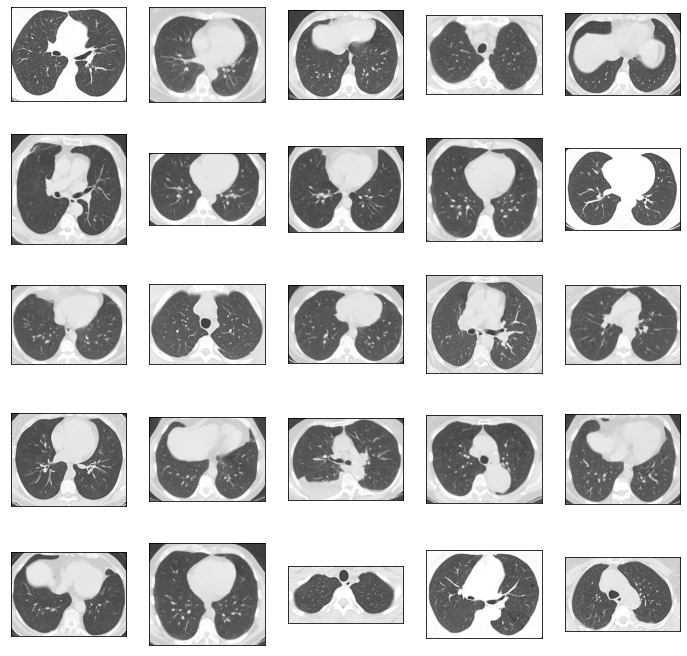

In [5]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            #img = mpimg.imread('your_image.png')
#imgplot = plt.imshow(img)
#plt.show()
            ax[i, j].imshow(mpimg.imread(image_path))
            n += 1
plot_defects('non-COVID', 5, 5)

# covid

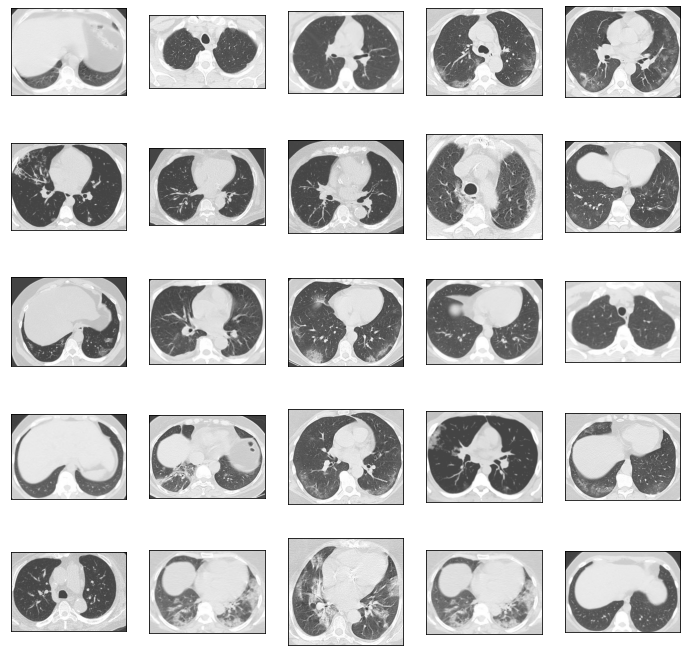

In [6]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            #ax[i, j].imshow(cv2.imread(image_path))
            ax[i, j].imshow(mpimg.imread(image_path))
            n += 1
plot_defects('COVID', 5, 5)

In [7]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [8]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2481it [00:06, 358.20it/s]

Train Shape: (2481, 64, 64, 3)


In [9]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [10]:
BATCH_SIZE = 64

X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

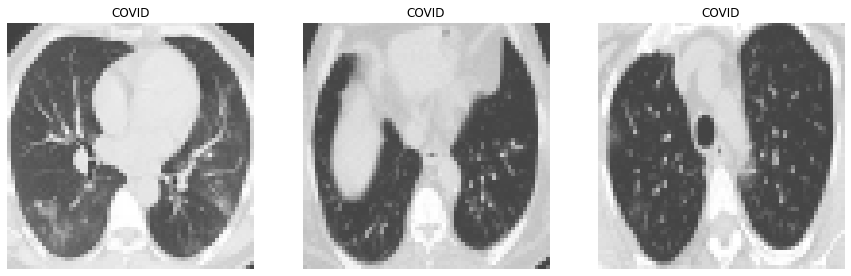

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [12]:
EPOCHS = 50
SIZE=64
N_ch=3


In [13]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)


    output = Dense(2,activation = 'softmax', name='root')(x)
 

    
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [14]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2, 
                        zoom_range=0.2,
                        horizontal_flip=True, 
                        vertical_flip=True) 

datagen.fit(X_train)

hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               26


Epoch 00037: val_loss did not improve from 0.25811
Epoch 38/50
 - 60s - loss: 0.2729 - accuracy: 0.8942 - val_loss: 0.3231 - val_accuracy: 0.8692

Epoch 00038: val_loss did not improve from 0.25811
Epoch 39/50
 - 60s - loss: 0.2592 - accuracy: 0.8957 - val_loss: 0.5745 - val_accuracy: 0.7465

Epoch 00039: val_loss did not improve from 0.25811
Epoch 40/50
 - 60s - loss: 0.2647 - accuracy: 0.8931 - val_loss: 0.3328 - val_accuracy: 0.8592

Epoch 00040: val_loss did not improve from 0.25811
Epoch 41/50
 - 60s - loss: 0.2543 - accuracy: 0.8982 - val_loss: 0.3029 - val_accuracy: 0.8632

Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00041: val_loss did not improve from 0.25811
Epoch 42/50
 - 60s - loss: 0.2453 - accuracy: 0.8992 - val_loss: 0.2695 - val_accuracy: 0.8833

Epoch 00042: val_loss did not improve from 0.25811
Epoch 43/50
 - 60s - loss: 0.2650 - accuracy: 0.8856 - val_loss: 0.2473 - val_accuracy: 0.9054

Epoch 00043: val_loss improved from 0.25811 to 0.247

In [15]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))


497/497 [==============================] - 4s 8ms/step
Final Loss: 0.3737067303787055, Final Accuracy: 0.8470824956893921
